In [1]:
import collections.abc
import math
from dataclasses import dataclass
from typing import Optional, Set, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

In [2]:
class DeiTEmbeddings(nn.Module):
    """
    Construct the CLS token, distillation token, position and patch embeddings. Optionally, also the mask token.
    """

    def __init__(self, num_channels, image_size, patch_size, hidden_size, hidden_dropout_prob, use_mask_token: bool = False) -> None:
        super().__init__()

        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.distillation_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, hidden_size)) if use_mask_token else None
        self.patch_embeddings = DeiTPatchEmbeddings(num_channels, image_size, patch_size, hidden_size)
        num_patches = self.patch_embeddings.num_patches
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches + 2, hidden_size))
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, pixel_values: torch.Tensor, bool_masked_pos: Optional[torch.BoolTensor] = None) -> torch.Tensor:
        embeddings = self.patch_embeddings(pixel_values)
        batch_size, seq_length, _ = embeddings.size()

        if bool_masked_pos is not None:
            mask_tokens = self.mask_token.expand(batch_size, seq_length, -1)
            # replace the masked visual tokens by mask_tokens
            mask = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)
            embeddings = embeddings * (1.0 - mask) + mask_tokens * mask

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        distillation_tokens = self.distillation_token.expand(batch_size, -1, -1)
        embeddings = torch.cat((cls_tokens, distillation_tokens, embeddings), dim=1)
        embeddings = embeddings + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


In [3]:
class DeiTPatchEmbeddings(nn.Module):
    """
    This class turns `pixel_values` of shape `(batch_size, num_channels, height, width)` into the initial
    `hidden_states` (patch embeddings) of shape `(batch_size, seq_length, hidden_size)` to be consumed by a
    Transformer.
    """

    def __init__(self, num_channels, image_size, patch_size, hidden_size):
        super().__init__()
        image_size, patch_size = image_size, patch_size
        num_channels, hidden_size = num_channels, hidden_size

        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        if num_channels != self.num_channels:
            raise ValueError(
                "Make sure that the channel dimension of the pixel values match with the one set in the configuration."
            )
        if height != self.image_size[0] or width != self.image_size[1]:
            raise ValueError(
                f"Input image size ({height}*{width}) doesn't match model ({self.image_size[0]}*{self.image_size[1]})."
            )
        x = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return x

In [4]:
class DeiTSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob) -> None:
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                f"The hidden size {hidden_size,} is not a multiple of the number of attention "
                f"heads {num_attention_heads}."
            )

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)
        self.key = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)
        self.value = nn.Linear(hidden_size, self.all_head_size, bias=qkv_bias)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self, hidden_states, head_mask: Optional[torch.Tensor] = None, output_attentions: bool = False
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs

In [5]:
class DeiTSelfOutput(nn.Module):
    """
    The residual connection is defined in DeiTLayer instead of here (as is the case with other models), due to the
    layernorm applied before each block.
    """

    def __init__(self, hidden_size, hidden_dropout_prob) -> None:
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states

In [6]:
class DeiTAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob) -> None:
        super().__init__()
        self.attention = DeiTSelfAttention(hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob)
        self.output = DeiTSelfOutput(hidden_size, hidden_dropout_prob)
        self.pruned_heads = set()

    def prune_heads(self, heads: Set[int]) -> None:
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_outputs = self.attention(hidden_states, head_mask, output_attentions)

        attention_output = self.output(self_outputs[0], hidden_states)

        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs

In [7]:
class DeiTIntermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size) -> None:
        super().__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        self.intermediate_act_fn = nn.GELU()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)

        return hidden_states

In [8]:
class DeiTOutput(nn.Module):
    def __init__(self, hidden_size, intermediate_size, hidden_dropout_prob) -> None:
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

In [9]:
class DeiTLayer(nn.Module):
    """This corresponds to the Block class in the timm implementation."""

    def __init__(self, chunk_size_feed_forward, hidden_size, intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, layer_norm_eps) -> None:
        super().__init__()
        self.chunk_size_feed_forward = chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = DeiTAttention(hidden_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob)
        self.intermediate = DeiTIntermediate(hidden_size, intermediate_size)
        self.output = DeiTOutput(hidden_size, intermediate_size, hidden_dropout_prob)
        self.layernorm_before = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(hidden_size, eps=layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor]]:
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in DeiT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        # first residual connection
        hidden_states = attention_output + hidden_states

        # in DeiT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)
        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)

        outputs = (layer_output,) + outputs

        return outputs

In [10]:
class DeiTEncoder(nn.Module):
    def __init__(self, num_hidden_layers, chunk_size_feed_forward, hidden_size, intermediate_size, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps) -> None:
        super().__init__()
        self.layer = nn.ModuleList([DeiTLayer(chunk_size_feed_forward, hidden_size, intermediate_size, num_attention_heads, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps) for _ in range(num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
        return_dict: bool = True,
    ) -> Union[tuple]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    layer_head_mask,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)


In [11]:
class DeiTModel(nn.Module):
    def __init__(self, num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, intermediate_size, 
                 num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, output_attentions,
                 output_hidden_states, use_return_dict, add_pooling_layer: bool = True, use_mask_token: bool = False) -> None:
        super().__init__()
        self.num_hidden_layers = num_hidden_layers

        self.embeddings = DeiTEmbeddings(num_channels, image_size, patch_size, hidden_size, hidden_dropout_prob, 
                                         use_mask_token=use_mask_token)
        self.encoder = DeiTEncoder(num_hidden_layers, chunk_size_feed_forward, hidden_size, intermediate_size, num_attention_heads, 
                 qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps)

        self.layernorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.pooler = DeiTPooler(hidden_size) if add_pooling_layer else None

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def get_input_embeddings(self) -> DeiTPatchEmbeddings:
        return self.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`, *optional*):
            Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = None
        #head_mask = self.get_head_mask(head_mask, self.num_hidden_layers)

        # TODO: maybe have a cleaner way to cast the input (from `ImageProcessor` side?)
        expected_dtype = self.embeddings.patch_embeddings.projection.weight.dtype
        if pixel_values.dtype != expected_dtype:
            pixel_values = pixel_values.to(expected_dtype)

        embedding_output = self.embeddings(pixel_values, bool_masked_pos=bool_masked_pos)

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            head_outputs = (sequence_output, pooled_output) if pooled_output is not None else (sequence_output,)
            return head_outputs + encoder_outputs[1:]


In [12]:
class DeiTPooler(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [13]:
class DeiTForMaskedImageModeling(nn.Module):
    def __init__(self, num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, intermediate_size, 
                 num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, encoder_stride, 
                 output_attentions, output_hidden_states, use_return_dict, add_pooling_layer) -> None:
        super().__init__()

        self.deit = DeiTModel(num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, 
                 intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps,
                 output_attentions, output_hidden_states, use_return_dict, add_pooling_layer, use_mask_token=True)

        self.decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_size,
                out_channels=encoder_stride**2 * num_channels,
                kernel_size=1,
            ),
            nn.PixelShuffle(encoder_stride),
        )

        # Initialize weights and apply final processing
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple]:
        r"""
        bool_masked_pos (`torch.BoolTensor` of shape `(batch_size, num_patches)`):
            Boolean masked positions. Indicates which patches are masked (1) and which aren't (0).
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, DeiTForMaskedImageModeling
        >>> import torch
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")
        >>> model = DeiTForMaskedImageModeling.from_pretrained("facebook/deit-base-distilled-patch16-224")
        >>> num_patches = (model.config.image_size // model.config.patch_size) ** 2
        >>> pixel_values = image_processor(images=image, return_tensors="pt").pixel_values
        >>> # create random boolean mask of shape (batch_size, num_patches)
        >>> bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()
        >>> outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
        >>> loss, reconstructed_pixel_values = outputs.loss, outputs.reconstruction
        >>> list(reconstructed_pixel_values.shape)
        [1, 3, 224, 224]
        ```"""
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        outputs = self.deit(
            pixel_values,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # Reshape to (batch_size, num_channels, height, width)
        sequence_output = sequence_output[:, 1:-1]
        batch_size, sequence_length, num_channels = sequence_output.shape
        height = width = int(sequence_length**0.5)
        sequence_output = sequence_output.permute(0, 2, 1).reshape(batch_size, num_channels, height, width)

        # Reconstruct pixel values
        reconstructed_pixel_values = self.decoder(sequence_output)

        masked_im_loss = None
        if bool_masked_pos is not None:
            size = self.image_size // self.patch_size
            bool_masked_pos = bool_masked_pos.reshape(-1, size, size)
            mask = (
                bool_masked_pos.repeat_interleave(self.patch_size, 1)
                .repeat_interleave(self.patch_size, 2)
                .unsqueeze(1)
                .contiguous()
            )
            reconstruction_loss = nn.functional.l1_loss(pixel_values, reconstructed_pixel_values, reduction="none")
            masked_im_loss = (reconstruction_loss * mask).sum() / (mask.sum() + 1e-5) / self.num_channels

        if not return_dict:
            output = (reconstructed_pixel_values,) + outputs[1:]
            return ((masked_im_loss,) + output) if masked_im_loss is not None else output


In [14]:
class DeiTForImageClassification(nn.Module):
    def __init__(self, num_labels, num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, 
                 intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, 
                 encoder_stride, output_attentions, output_hidden_states, use_return_dict) -> None:
        super().__init__()

        self.num_labels = num_labels
        self.deit = DeiTModel(num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, 
                 intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, 
                 output_attentions, output_hidden_states, use_return_dict, add_pooling_layer=False)

        # Classifier head
        self.classifier = nn.Linear(hidden_size, num_labels) if num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, DeiTForImageClassification
        >>> import torch
        >>> from PIL import Image
        >>> import requests
        >>> torch.manual_seed(3)  # doctest: +IGNORE_RESULT
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> # note: we are loading a DeiTForImageClassificationWithTeacher from the hub here,
        >>> # so the head will be randomly initialized, hence the predictions will be random
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")
        >>> model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224")
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> outputs = model(**inputs)
        >>> logits = outputs.logits
        >>> # model predicts one of the 1000 ImageNet classes
        >>> predicted_class_idx = logits.argmax(-1).item()
        >>> print("Predicted class:", model.config.id2label[predicted_class_idx])
        Predicted class: magpie
        ```"""
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        outputs = self.deit(
            pixel_values,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])
        # we don't use the distillation token

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output


In [15]:
class DeiTForImageClassificationWithTeacher(nn.Module):
    def __init__(self, num_labels, num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, 
                 intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, 
                 encoder_stride, output_attentions, output_hidden_states, use_return_dict) -> None:
        super().__init__()

        self.num_labels = num_labels
        self.deit = DeiTModel(num_channels, image_size, patch_size, hidden_size, num_hidden_layers, chunk_size_feed_forward, 
                 intermediate_size, num_attention_heads, qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, layer_norm_eps, 
                 output_attentions, output_hidden_states, use_return_dict, add_pooling_layer=False)

        # Classifier heads
        self.cls_classifier = (
            nn.Linear(hidden_size, num_labels) if num_labels > 0 else nn.Identity()
        )
        self.distillation_classifier = (
            nn.Linear(hidden_size, num_labels) if num_labels > 0 else nn.Identity()
        )

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple]:
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        outputs = self.deit(
            pixel_values,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        cls_logits = self.cls_classifier(sequence_output[:, 0, :])
        distillation_logits = self.distillation_classifier(sequence_output[:, 1, :])

        # during inference, return the average of both classifier predictions
        logits = (cls_logits + distillation_logits) / 2

        if not return_dict:
            output = (logits, cls_logits, distillation_logits) + outputs[1:]
            return output


In [16]:
num_labels=10
num_channels=3
image_size=32
patch_size=4
hidden_size=64
num_hidden_layers=4
chunk_size_feed_forward=0
intermediate_size=128
num_attention_heads=4
qkv_bias=True
attention_probs_dropout_prob=0
hidden_dropout_prob=0
layer_norm_eps=1e-12
encoder_stride=1
output_attentions=True
output_hidden_states=True
use_return_dict=False

modelClassification = DeiTForImageClassificationWithTeacher(
    num_labels=num_labels,
    num_channels=num_channels,
    image_size=image_size,
    patch_size=patch_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    chunk_size_feed_forward=chunk_size_feed_forward,
    intermediate_size=intermediate_size,
    num_attention_heads=num_attention_heads,
    qkv_bias=qkv_bias,
    attention_probs_dropout_prob=attention_probs_dropout_prob,
    hidden_dropout_prob=hidden_dropout_prob,
    layer_norm_eps=layer_norm_eps,
    encoder_stride=encoder_stride,
    output_attentions=output_attentions,
    output_hidden_states=output_hidden_states,
    use_return_dict=use_return_dict
)

In [17]:
sample_image = torch.rand(5, 3, 32, 32)
outputs = modelClassification(pixel_values=sample_image)
logits, cls_logits, distillation_logits, all_hidden_states, all_self_attentions = outputs
print("logits shape:", logits.shape)

logits shape: torch.Size([5, 10])


In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [19]:
batch_size = 64
learning_rate = 3e-4
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [21]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [22]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

horse


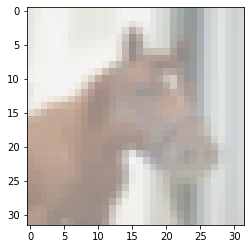

In [23]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelClassification.parameters(), lr=learning_rate)

In [25]:
num_epochs = 500
device = torch.device('cpu')

In [26]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        logits, mask, ids_restore, hidden_states, attentions= modelClassification(pixel_values=data)
        loss = criterion(logits, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.4468547105789185


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Loss: 1.3225479125976562


  0%|                                                                                  | 1/782 [00:00<02:37,  4.95it/s]

Epoch: 2 Loss: 1.1820322275161743


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Loss: 1.4023586511611938


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.8000003099441528


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 5 Loss: 1.1812463998794556


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 1.6302001476287842


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 7 Loss: 1.0746616125106812


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 8 Loss: 1.5281504392623901


  0%|                                                                                  | 1/782 [00:00<02:06,  6.17it/s]

Epoch: 9 Loss: 0.8743079304695129


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 10 Loss: 1.2515320777893066


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 11 Loss: 1.097980260848999


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 12 Loss: 1.0052430629730225


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.6796602010726929


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 14 Loss: 0.9087454676628113


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.5759682655334473


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 16 Loss: 0.3276171386241913


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Loss: 1.0833007097244263


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 18 Loss: 0.41870471835136414


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 19 Loss: 0.4321660101413727


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 20 Loss: 0.8820359706878662


  0%|                                                                                  | 1/782 [00:00<02:28,  5.26it/s]

Epoch: 21 Loss: 0.9249551296234131


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 22 Loss: 0.6521594524383545


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 23 Loss: 0.5794021487236023


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 24 Loss: 0.5875751972198486


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 25 Loss: 0.4907911419868469


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 26 Loss: 0.7106710076332092


  0%|                                                                                  | 1/782 [00:00<01:47,  7.30it/s]

Epoch: 27 Loss: 0.32234087586402893


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 28 Loss: 0.30834898352622986


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 29 Loss: 0.6278868913650513


  0%|                                                                                  | 1/782 [00:00<02:29,  5.21it/s]

Epoch: 30 Loss: 0.6775319576263428


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 31 Loss: 0.2692200839519501


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 32 Loss: 0.5239683985710144


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 33 Loss: 0.9115645885467529


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 34 Loss: 0.17944304645061493


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 35 Loss: 0.2718609869480133


  0%|                                                                                  | 1/782 [00:00<01:53,  6.89it/s]

Epoch: 36 Loss: 0.22964772582054138


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 37 Loss: 0.33576419949531555


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 38 Loss: 0.22349217534065247


  0%|                                                                                  | 1/782 [00:00<01:53,  6.89it/s]

Epoch: 39 Loss: 0.3550792634487152


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 40 Loss: 0.20814372599124908


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 41 Loss: 0.5735639333724976


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 42 Loss: 0.3831581473350525


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 43 Loss: 0.30352210998535156


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 44 Loss: 0.07232838869094849


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 45 Loss: 0.0731610357761383


  0%|                                                                                  | 1/782 [00:00<02:17,  5.68it/s]

Epoch: 46 Loss: 0.2709077000617981


  0%|                                                                                  | 1/782 [00:00<02:35,  5.02it/s]

Epoch: 47 Loss: 0.1565500795841217


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 48 Loss: 0.09377328306436539


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 49 Loss: 0.04034997150301933


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 50 Loss: 0.1174544021487236


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 51 Loss: 0.1183871254324913


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 52 Loss: 0.35795173048973083


  0%|                                                                                  | 1/782 [00:00<02:29,  5.23it/s]

Epoch: 53 Loss: 0.16363759338855743


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 54 Loss: 0.4298313558101654


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 55 Loss: 0.12374603748321533


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 56 Loss: 0.23460765182971954


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 57 Loss: 0.1790432333946228


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 58 Loss: 0.1802670806646347


  0%|                                                                                  | 1/782 [00:00<02:32,  5.13it/s]

Epoch: 59 Loss: 0.18620337545871735


  0%|                                                                                  | 1/782 [00:00<02:27,  5.29it/s]

Epoch: 60 Loss: 0.1702994704246521


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 61 Loss: 0.024373451247811317


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 62 Loss: 0.2429371029138565


  0%|                                                                                  | 1/782 [00:00<01:46,  7.35it/s]

Epoch: 63 Loss: 0.17038896679878235


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 64 Loss: 0.3665975332260132


  0%|                                                                                  | 1/782 [00:00<02:28,  5.26it/s]

Epoch: 65 Loss: 0.03559897094964981


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 66 Loss: 0.005445342045277357


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 67 Loss: 0.1648353934288025


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 68 Loss: 0.04269697144627571


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 69 Loss: 0.16222065687179565


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 70 Loss: 0.12543252110481262


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 71 Loss: 0.22571584582328796


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 72 Loss: 0.4742245078086853


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 73 Loss: 0.21782197058200836


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 74 Loss: 0.008874518796801567


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 75 Loss: 0.29030629992485046


  0%|                                                                                  | 1/782 [00:00<02:08,  6.10it/s]

Epoch: 76 Loss: 0.06644239276647568


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 77 Loss: 0.023395823314785957


  0%|                                                                                  | 1/782 [00:00<01:55,  6.75it/s]

Epoch: 78 Loss: 0.10319384187459946


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 79 Loss: 0.18908245861530304


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 80 Loss: 0.14041398465633392


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 81 Loss: 0.11644453555345535


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 82 Loss: 0.04357917606830597


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 83 Loss: 0.09748709201812744


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 84 Loss: 0.14708688855171204


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 85 Loss: 0.1321353167295456


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 86 Loss: 0.16429521143436432


  0%|                                                                                  | 1/782 [00:00<02:26,  5.35it/s]

Epoch: 87 Loss: 0.08795738220214844


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 88 Loss: 0.04485035687685013


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 89 Loss: 0.05262662470340729


  0%|                                                                                  | 1/782 [00:00<02:41,  4.83it/s]

Epoch: 90 Loss: 0.037246495485305786


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 91 Loss: 0.05679896101355553


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 92 Loss: 0.08209408074617386


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 93 Loss: 0.02782551571726799


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 94 Loss: 0.028833070769906044


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 95 Loss: 0.03001326508820057


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 96 Loss: 0.03244269639253616


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 97 Loss: 0.048557113856077194


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 98 Loss: 0.200282022356987


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 99 Loss: 0.02256290800869465


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 100 Loss: 0.03629272058606148


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 101 Loss: 0.2742258310317993


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 102 Loss: 0.04861908406019211


  0%|                                                                                  | 1/782 [00:00<02:21,  5.52it/s]

Epoch: 103 Loss: 0.03812235966324806


  0%|                                                                                  | 1/782 [00:00<02:13,  5.85it/s]

Epoch: 104 Loss: 0.08835810422897339


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 105 Loss: 0.016170036047697067


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 106 Loss: 0.18793417513370514


  0%|                                                                                  | 1/782 [00:00<01:57,  6.67it/s]

Epoch: 107 Loss: 0.007301913574337959


  0%|                                                                                  | 1/782 [00:00<02:26,  5.35it/s]

Epoch: 108 Loss: 0.15108977258205414


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 109 Loss: 0.04442974925041199


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 110 Loss: 0.028579214587807655


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 111 Loss: 0.0851551741361618


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 112 Loss: 0.4163648784160614


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 113 Loss: 0.0156633909791708


  0%|                                                                                  | 1/782 [00:00<02:18,  5.65it/s]

Epoch: 114 Loss: 0.031861767172813416


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 115 Loss: 0.04611313343048096


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 116 Loss: 0.1100681871175766


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 117 Loss: 0.005881516728550196


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 118 Loss: 0.0010732102673500776


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 119 Loss: 0.09774287045001984


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 120 Loss: 0.052210837602615356


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 121 Loss: 0.04330385848879814


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 122 Loss: 0.03500446677207947


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 123 Loss: 0.12438677251338959


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 124 Loss: 0.10492192953824997


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 125 Loss: 0.21777404844760895


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 126 Loss: 0.07156386226415634


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 127 Loss: 0.025134654715657234


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 128 Loss: 0.0010365674970671535


  0%|                                                                                  | 1/782 [00:00<01:53,  6.89it/s]

Epoch: 129 Loss: 0.0852869302034378


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 130 Loss: 0.008615691214799881


  0%|                                                                                  | 1/782 [00:00<02:27,  5.29it/s]

Epoch: 131 Loss: 0.22607290744781494


  0%|                                                                                  | 1/782 [00:00<02:15,  5.75it/s]

Epoch: 132 Loss: 0.01436860952526331


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 133 Loss: 0.18054381012916565


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 134 Loss: 0.05898893624544144


  0%|                                                                                  | 1/782 [00:00<02:29,  5.21it/s]

Epoch: 135 Loss: 0.009190015494823456


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 136 Loss: 0.03590663522481918


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 137 Loss: 0.23832395672798157


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 138 Loss: 0.10473787039518356


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 139 Loss: 0.10144685208797455


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 140 Loss: 0.1883740872144699


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 141 Loss: 0.1925097405910492


  0%|                                                                                  | 1/782 [00:00<02:21,  5.52it/s]

Epoch: 142 Loss: 0.03656120225787163


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 143 Loss: 0.09902366995811462


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 144 Loss: 0.008378177881240845


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 145 Loss: 0.03786430135369301


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 146 Loss: 0.0014113296056166291


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 147 Loss: 0.0031429931987076998


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 148 Loss: 0.014516904018819332


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 149 Loss: 0.09801626205444336


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 150 Loss: 0.00957897212356329


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 151 Loss: 0.04165845364332199


  0%|                                                                                  | 1/782 [00:00<02:07,  6.13it/s]

Epoch: 152 Loss: 0.002093186369165778


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 153 Loss: 0.0016987526323646307


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 154 Loss: 0.08665808290243149


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 155 Loss: 0.0880783349275589


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 156 Loss: 0.09410637617111206


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 157 Loss: 0.010038365609943867


  0%|                                                                                  | 1/782 [00:00<02:12,  5.92it/s]

Epoch: 158 Loss: 0.12862646579742432


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 159 Loss: 0.0512324720621109


  0%|                                                                                  | 1/782 [00:00<01:47,  7.30it/s]

Epoch: 160 Loss: 0.00470697320997715


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 161 Loss: 0.03015177883207798


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 162 Loss: 0.00967254675924778


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 163 Loss: 0.02383032627403736


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 164 Loss: 0.07814627140760422


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 165 Loss: 0.0062671685591340065


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 166 Loss: 0.010046840645372868


  0%|                                                                                  | 1/782 [00:00<02:10,  5.99it/s]

Epoch: 167 Loss: 0.06663991510868073


  0%|                                                                                  | 1/782 [00:00<02:28,  5.26it/s]

Epoch: 168 Loss: 0.000816277286503464


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 169 Loss: 0.1187913715839386


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 170 Loss: 0.001740573439747095


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 171 Loss: 0.3816582262516022


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 172 Loss: 0.06827123463153839


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 173 Loss: 0.16774310171604156


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 174 Loss: 0.0027387887239456177


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 175 Loss: 0.301626980304718


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 176 Loss: 0.03978279232978821


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 177 Loss: 0.055683258920907974


  0%|                                                                                  | 1/782 [00:00<02:35,  5.02it/s]

Epoch: 178 Loss: 0.1334833800792694


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 179 Loss: 0.0052463519386947155


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 180 Loss: 0.004498528316617012


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 181 Loss: 0.008178836666047573


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 182 Loss: 0.011565305292606354


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 183 Loss: 0.002982544945552945


  0%|                                                                                  | 1/782 [00:00<02:33,  5.10it/s]

Epoch: 184 Loss: 0.00852424930781126


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 185 Loss: 0.01349917333573103


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 186 Loss: 0.007216011174023151


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 187 Loss: 0.011813032440841198


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 188 Loss: 0.04523767530918121


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 189 Loss: 0.0007431920384988189


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 190 Loss: 0.039815738797187805


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 191 Loss: 0.0026507375296205282


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 192 Loss: 0.0051835994236171246


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 193 Loss: 0.0015174231957644224


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 194 Loss: 0.0040400768630206585


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 195 Loss: 0.055733442306518555


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 196 Loss: 0.01833893544971943


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 197 Loss: 0.07675868272781372


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 198 Loss: 0.022049501538276672


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 199 Loss: 0.017509112134575844


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 200 Loss: 0.0002650838578119874


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 201 Loss: 0.04067300260066986


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 202 Loss: 0.004652826115489006


  0%|                                                                                  | 1/782 [00:00<02:30,  5.18it/s]

Epoch: 203 Loss: 0.0009490994270890951


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 204 Loss: 0.06534652411937714


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 205 Loss: 0.052724193781614304


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 206 Loss: 0.055898554623126984


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 207 Loss: 0.004268699791282415


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 208 Loss: 0.006250413600355387


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 209 Loss: 0.05604104325175285


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 210 Loss: 0.01379486545920372


  0%|                                                                                  | 1/782 [00:00<02:34,  5.05it/s]

Epoch: 211 Loss: 0.012516908347606659


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 212 Loss: 0.0006261640810407698


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 213 Loss: 0.11211616545915604


  0%|                                                                                  | 1/782 [00:00<02:35,  5.02it/s]

Epoch: 214 Loss: 0.007397023029625416


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 215 Loss: 0.10891744494438171


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 216 Loss: 0.003381202230229974


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 217 Loss: 0.08880506455898285


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 218 Loss: 0.00496478658169508


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 219 Loss: 0.032366104423999786


  0%|                                                                                  | 1/782 [00:00<02:06,  6.17it/s]

Epoch: 220 Loss: 0.015462364070117474


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 221 Loss: 0.015474134124815464


  0%|                                                                                  | 1/782 [00:00<02:32,  5.13it/s]

Epoch: 222 Loss: 0.0007536020711995661


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 223 Loss: 0.003485902678221464


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 224 Loss: 0.00984965730458498


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 225 Loss: 0.019948549568653107


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 226 Loss: 0.0024791781324893236


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 227 Loss: 0.06420416384935379


  0%|                                                                                  | 1/782 [00:00<02:29,  5.23it/s]

Epoch: 228 Loss: 0.16201388835906982


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 229 Loss: 0.2430238276720047


  0%|                                                                                  | 1/782 [00:00<02:11,  5.95it/s]

Epoch: 230 Loss: 0.012608393095433712


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 231 Loss: 0.007088721264153719


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 232 Loss: 0.01997452601790428


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 233 Loss: 0.01319072488695383


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 234 Loss: 0.24391816556453705


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 235 Loss: 0.007981006056070328


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 236 Loss: 0.07562718540430069


  0%|                                                                                  | 1/782 [00:00<02:07,  6.13it/s]

Epoch: 237 Loss: 0.0020667368080466986


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 238 Loss: 0.017096877098083496


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 239 Loss: 0.002624629531055689


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 240 Loss: 0.06432409584522247


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 241 Loss: 0.18596380949020386


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 242 Loss: 0.03365654870867729


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 243 Loss: 0.024775099009275436


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 244 Loss: 0.42298460006713867


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 245 Loss: 0.00884272065013647


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 246 Loss: 0.008413850329816341


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 247 Loss: 0.13391326367855072


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 248 Loss: 0.010624812915921211


  0%|                                                                                  | 1/782 [00:00<01:48,  7.19it/s]

Epoch: 249 Loss: 0.01747351884841919


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 250 Loss: 0.005527381785213947


  0%|                                                                                  | 1/782 [00:00<02:30,  5.18it/s]

Epoch: 251 Loss: 0.011976441368460655


  0%|                                                                                  | 1/782 [00:00<02:34,  5.05it/s]

Epoch: 252 Loss: 0.0006084633059799671


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 253 Loss: 0.00045785598922520876


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 254 Loss: 0.5446415543556213


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 255 Loss: 0.07378295063972473


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 256 Loss: 0.00035932654282078147


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 257 Loss: 0.009934285655617714


  0%|                                                                                  | 1/782 [00:00<02:31,  5.15it/s]

Epoch: 258 Loss: 0.0009029317880049348


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 259 Loss: 0.0055558402091264725


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 260 Loss: 0.07540225237607956


  0%|                                                                                  | 1/782 [00:00<02:37,  4.95it/s]

Epoch: 261 Loss: 0.01091641467064619


  0%|                                                                                  | 1/782 [00:00<02:07,  6.13it/s]

Epoch: 262 Loss: 0.00042880664113909006


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 263 Loss: 0.02180166356265545


  0%|                                                                                  | 1/782 [00:00<02:40,  4.85it/s]

Epoch: 264 Loss: 0.003504376159980893


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 265 Loss: 0.002980591030791402


  0%|                                                                                  | 1/782 [00:00<02:15,  5.78it/s]

Epoch: 266 Loss: 0.004665695130825043


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 267 Loss: 0.08015912771224976


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 268 Loss: 0.022961867973208427


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 269 Loss: 0.00038826605305075645


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 270 Loss: 0.00019544907263480127


  0%|                                                                                  | 1/782 [00:00<02:08,  6.10it/s]

Epoch: 271 Loss: 0.005661181639879942


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 272 Loss: 0.15829353034496307


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 273 Loss: 0.003088237950578332


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 274 Loss: 0.016100997105240822


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 275 Loss: 0.010793969966471195


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 276 Loss: 0.00024120886519085616


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 277 Loss: 0.018794918432831764


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 278 Loss: 0.012389476411044598


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 279 Loss: 0.028688861057162285


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 280 Loss: 0.009019999764859676


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 281 Loss: 0.0038737196009606123


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 282 Loss: 0.006196856964379549


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 283 Loss: 0.2037416398525238


  0%|                                                                                  | 1/782 [00:00<02:38,  4.93it/s]

Epoch: 284 Loss: 0.0003360035771038383


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 285 Loss: 0.002871741773560643


  0%|                                                                                  | 1/782 [00:00<01:51,  6.99it/s]

Epoch: 286 Loss: 0.0304262675344944


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 287 Loss: 0.0079931216314435


  0%|                                                                                  | 1/782 [00:00<02:21,  5.52it/s]

Epoch: 288 Loss: 0.004808490630239248


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 289 Loss: 0.0022773360833525658


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 290 Loss: 0.005557063035666943


  0%|                                                                                  | 1/782 [00:00<02:39,  4.90it/s]

Epoch: 291 Loss: 0.0021038686390966177


  0%|                                                                                  | 1/782 [00:00<01:56,  6.71it/s]

Epoch: 292 Loss: 0.0037944477517157793


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 293 Loss: 0.0016893809661269188


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 294 Loss: 0.010556714609265327


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 295 Loss: 0.0063821738585829735


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 296 Loss: 0.016203731298446655


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 297 Loss: 0.001436716178432107


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 298 Loss: 0.003781368723139167


  0%|                                                                                  | 1/782 [00:00<01:47,  7.25it/s]

Epoch: 299 Loss: 0.02261081524193287


  0%|                                                                                  | 1/782 [00:00<02:24,  5.40it/s]

Epoch: 300 Loss: 0.11529463529586792


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 301 Loss: 0.0009102652547881007


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 302 Loss: 0.02416042424738407


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 303 Loss: 0.0026163235306739807


  0%|                                                                                  | 1/782 [00:00<01:57,  6.62it/s]

Epoch: 304 Loss: 0.00029094444471411407


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 305 Loss: 0.02493853121995926


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 306 Loss: 0.0023848852142691612


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 307 Loss: 0.005691942293196917


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 308 Loss: 0.04473169893026352


  0%|                                                                                  | 1/782 [00:00<02:27,  5.29it/s]

Epoch: 309 Loss: 0.002179704839363694


  0%|                                                                                  | 1/782 [00:00<02:31,  5.15it/s]

Epoch: 310 Loss: 0.0005999215063638985


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 311 Loss: 0.0580194815993309


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 312 Loss: 0.186904639005661


  0%|                                                                                  | 1/782 [00:00<02:00,  6.49it/s]

Epoch: 313 Loss: 0.25313684344291687


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 314 Loss: 0.0029995343647897243


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 315 Loss: 0.05163858085870743


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 316 Loss: 0.00046937944716773927


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 317 Loss: 0.0002100047713611275


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 318 Loss: 0.06650275737047195


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 319 Loss: 0.010746646672487259


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 320 Loss: 0.012896806932985783


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 321 Loss: 0.004457877948880196


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 322 Loss: 0.0630003809928894


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 323 Loss: 0.0042877644300460815


  0%|                                                                                  | 1/782 [00:00<02:34,  5.05it/s]

Epoch: 324 Loss: 0.06249932572245598


  0%|                                                                                  | 1/782 [00:00<01:47,  7.30it/s]

Epoch: 325 Loss: 0.0006576110026799142


  0%|                                                                                  | 1/782 [00:00<01:54,  6.80it/s]

Epoch: 326 Loss: 0.060984157025814056


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 327 Loss: 0.05689992755651474


  0%|                                                                                  | 1/782 [00:00<02:34,  5.05it/s]

Epoch: 328 Loss: 0.0008426749845966697


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 329 Loss: 0.002547707874327898


  0%|                                                                                  | 1/782 [00:00<01:44,  7.46it/s]

Epoch: 330 Loss: 0.0019927469547837973


  0%|                                                                                  | 1/782 [00:00<02:32,  5.13it/s]

Epoch: 331 Loss: 0.01847250945866108


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 332 Loss: 0.08053514361381531


  0%|                                                                                  | 1/782 [00:00<02:12,  5.92it/s]

Epoch: 333 Loss: 0.008558805100619793


  0%|                                                                                  | 1/782 [00:00<02:07,  6.13it/s]

Epoch: 334 Loss: 0.002180861309170723


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 335 Loss: 0.13747501373291016


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 336 Loss: 0.032898902893066406


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 337 Loss: 0.005125167313963175


  0%|                                                                                  | 1/782 [00:00<02:23,  5.43it/s]

Epoch: 338 Loss: 0.17390833795070648


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 339 Loss: 0.0016245516017079353


  0%|                                                                                  | 1/782 [00:00<01:59,  6.53it/s]

Epoch: 340 Loss: 0.030526963993906975


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 341 Loss: 0.001743352971971035


  0%|                                                                                  | 1/782 [00:00<02:12,  5.92it/s]

Epoch: 342 Loss: 0.20366144180297852


  0%|                                                                                  | 1/782 [00:00<02:11,  5.95it/s]

Epoch: 343 Loss: 0.041058607399463654


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 344 Loss: 0.0002206445496995002


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 345 Loss: 8.78714636201039e-05


  0%|                                                                                  | 1/782 [00:00<02:30,  5.18it/s]

Epoch: 346 Loss: 7.521224324591458e-05


  0%|                                                                                  | 1/782 [00:00<02:12,  5.88it/s]

Epoch: 347 Loss: 0.015095457434654236


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 348 Loss: 0.1974499225616455


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 349 Loss: 0.0011514932848513126


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 350 Loss: 0.0006640010979026556


  0%|                                                                                  | 1/782 [00:00<02:08,  6.10it/s]

Epoch: 351 Loss: 0.0014707337832078338


  0%|                                                                                  | 1/782 [00:00<02:01,  6.45it/s]

Epoch: 352 Loss: 0.0028534538578242064


  0%|                                                                                  | 1/782 [00:00<02:07,  6.13it/s]

Epoch: 353 Loss: 0.00017886060231830925


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 354 Loss: 0.00017758319154381752


  0%|                                                                                  | 1/782 [00:00<01:47,  7.24it/s]

Epoch: 355 Loss: 0.06535177677869797


  0%|                                                                                  | 1/782 [00:00<02:24,  5.40it/s]

Epoch: 356 Loss: 0.07553862035274506


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 357 Loss: 0.02361946552991867


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 358 Loss: 0.00677628954872489


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 359 Loss: 0.010009183548390865


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 360 Loss: 0.04842943325638771


  0%|                                                                                  | 1/782 [00:00<01:50,  7.09it/s]

Epoch: 361 Loss: 0.0016560576623305678


  0%|                                                                                  | 1/782 [00:00<02:31,  5.15it/s]

Epoch: 362 Loss: 0.08705445379018784


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 363 Loss: 0.021671008318662643


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 364 Loss: 0.023217255249619484


  0%|                                                                                  | 1/782 [00:00<02:34,  5.05it/s]

Epoch: 365 Loss: 0.004805822856724262


  0%|                                                                                  | 1/782 [00:00<02:20,  5.55it/s]

Epoch: 366 Loss: 0.0007180472020991147


  0%|                                                                                  | 1/782 [00:00<02:04,  6.25it/s]

Epoch: 367 Loss: 0.00953131727874279


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 368 Loss: 0.018031323328614235


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 369 Loss: 0.04394135996699333


  0%|                                                                                  | 1/782 [00:00<02:13,  5.85it/s]

Epoch: 370 Loss: 0.0707373321056366


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 371 Loss: 0.006568534765392542


  0%|                                                                                  | 1/782 [00:00<02:03,  6.33it/s]

Epoch: 372 Loss: 0.009234102442860603


  0%|                                                                                  | 1/782 [00:00<02:33,  5.07it/s]

Epoch: 373 Loss: 0.2807982861995697


  0%|                                                                                  | 1/782 [00:00<02:32,  5.13it/s]

Epoch: 374 Loss: 0.0006048644427210093


  0%|                                                                                  | 1/782 [00:00<02:05,  6.21it/s]

Epoch: 375 Loss: 0.03216063603758812


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 376 Loss: 0.013219758868217468


  0%|                                                                                  | 1/782 [00:00<01:53,  6.89it/s]

Epoch: 377 Loss: 0.022400712594389915


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 378 Loss: 0.01220383495092392


  0%|                                                                                  | 1/782 [00:00<01:54,  6.85it/s]

Epoch: 379 Loss: 0.0012546343496069312


  0%|                                                                                  | 1/782 [00:00<01:49,  7.14it/s]

Epoch: 380 Loss: 0.01217230036854744


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 381 Loss: 0.0020542002748697996


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 382 Loss: 0.1436581164598465


  0%|                                                                                  | 1/782 [00:00<01:50,  7.04it/s]

Epoch: 383 Loss: 0.0003105174982920289


  0%|                                                                                  | 1/782 [00:00<02:04,  6.29it/s]

Epoch: 384 Loss: 0.0015163755742833018


  0%|                                                                                  | 1/782 [00:00<01:55,  6.76it/s]

Epoch: 385 Loss: 0.004617572762072086


  0%|                                                                                  | 1/782 [00:00<02:28,  5.26it/s]

Epoch: 386 Loss: 0.003983622416853905


  0%|                                                                                  | 1/782 [00:00<02:02,  6.37it/s]

Epoch: 387 Loss: 0.022662751376628876


  0%|                                                                                  | 1/782 [00:00<01:52,  6.94it/s]

Epoch: 388 Loss: 0.00010734394163591787


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 389 Loss: 0.2840111553668976


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 390 Loss: 0.0007380230817943811


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 391 Loss: 0.0011430162703618407


  0%|                                                                                  | 1/782 [00:00<02:18,  5.65it/s]

Epoch: 392 Loss: 0.0004779929295182228


  0%|                                                                                  | 1/782 [00:00<02:18,  5.65it/s]

Epoch: 393 Loss: 0.0050652045756578445


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 394 Loss: 0.0007851849659346044


  0%|                                                                                  | 1/782 [00:00<02:01,  6.41it/s]

Epoch: 395 Loss: 0.03917873278260231


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 396 Loss: 0.0017641045851632953


  0%|                                                                                  | 1/782 [00:00<01:53,  6.90it/s]

Epoch: 397 Loss: 0.007845588028430939


  0%|                                                                                  | 1/782 [00:00<01:58,  6.58it/s]

Epoch: 398 Loss: 0.0824040099978447


  0%|                                                                                  | 1/782 [00:00<02:23,  5.43it/s]

Epoch: 399 Loss: 0.00401702243834734


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 400 Loss: 6.730934546794742e-05


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 401 Loss: 0.11127740889787674


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.20it/s]

Epoch: 402 Loss: 0.01800571382045746


  0%|                                                                                  | 1/782 [00:00<01:18, 10.00it/s]

Epoch: 403 Loss: 0.002104212064296007


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.31it/s]

Epoch: 404 Loss: 0.00508193951100111


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 405 Loss: 0.020495131611824036


  0%|                                                                                  | 1/782 [00:00<01:18,  9.90it/s]

Epoch: 406 Loss: 0.00037060899194329977


  0%|                                                                                  | 1/782 [00:00<01:18, 10.00it/s]

Epoch: 407 Loss: 0.005784777458757162


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 408 Loss: 0.02903900109231472


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 409 Loss: 0.0027626785449683666


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.47it/s]

Epoch: 410 Loss: 0.00883487332612276


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 411 Loss: 0.10790899395942688


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 412 Loss: 0.001795459073036909


  0%|                                                                                  | 1/782 [00:00<01:19,  9.80it/s]

Epoch: 413 Loss: 0.0018081318121403456


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 414 Loss: 0.00012586229422595352


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 415 Loss: 0.0034577720798552036


  0%|                                                                                  | 1/782 [00:00<01:18, 10.00it/s]

Epoch: 416 Loss: 0.0420214906334877


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 417 Loss: 0.2849232256412506


  0%|                                                                                  | 1/782 [00:00<01:18, 10.00it/s]

Epoch: 418 Loss: 1.2322998372837901e-05


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 419 Loss: 0.0029665809124708176


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.15it/s]

Epoch: 420 Loss: 0.18675051629543304


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 421 Loss: 0.012555157765746117


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 422 Loss: 0.0002788309648167342


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.47it/s]

Epoch: 423 Loss: 0.00032408221159130335


  0%|▏                                                                                 | 2/782 [00:00<01:17, 10.10it/s]

Epoch: 424 Loss: 0.0027166311629116535


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 425 Loss: 0.0006448848871514201


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 426 Loss: 0.0006296196952462196


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.15it/s]

Epoch: 427 Loss: 9.470583609072492e-05


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.20it/s]

Epoch: 428 Loss: 0.024870790541172028


  0%|▏                                                                                 | 2/782 [00:00<01:17, 10.10it/s]

Epoch: 429 Loss: 0.00490514887496829


  0%|                                                                                  | 1/782 [00:00<01:18,  9.90it/s]

Epoch: 430 Loss: 0.032941821962594986


  0%|                                                                                  | 1/782 [00:00<01:18, 10.00it/s]

Epoch: 431 Loss: 0.0032807744573801756


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 432 Loss: 0.05097650736570358


  0%|                                                                                  | 1/782 [00:00<01:19,  9.80it/s]

Epoch: 433 Loss: 0.004617148078978062


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 434 Loss: 0.01871378906071186


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 435 Loss: 0.002854353981092572


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.15it/s]

Epoch: 436 Loss: 0.002383211860433221


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 437 Loss: 0.00167460972443223


  0%|                                                                                  | 1/782 [00:00<01:18,  9.90it/s]

Epoch: 438 Loss: 0.05328413099050522


  0%|▏                                                                                 | 2/782 [00:00<01:17, 10.10it/s]

Epoch: 439 Loss: 0.008919584564864635


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.31it/s]

Epoch: 440 Loss: 0.0028975424356758595


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 441 Loss: 0.0014161424478515983


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.47it/s]

Epoch: 442 Loss: 0.005593009293079376


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 443 Loss: 0.004563075490295887


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 444 Loss: 0.001690276199951768


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 445 Loss: 3.513185220072046e-05


  0%|                                                                                  | 1/782 [00:00<01:23,  9.34it/s]

Epoch: 446 Loss: 0.007581049110740423


  0%|▏                                                                                 | 2/782 [00:00<01:11, 10.87it/s]

Epoch: 447 Loss: 0.0025604560505598783


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.47it/s]

Epoch: 448 Loss: 0.04129332676529884


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 449 Loss: 0.012211479246616364


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 450 Loss: 0.001454442972317338


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 451 Loss: 0.0020956764928996563


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 452 Loss: 0.0006958816084079444


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 453 Loss: 0.044480208307504654


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.69it/s]

Epoch: 454 Loss: 0.23782208561897278


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 455 Loss: 0.0009248493588529527


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 456 Loss: 0.17986172437667847


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 457 Loss: 0.001703081652522087


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 458 Loss: 0.0007927321712486446


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 459 Loss: 0.005944882053881884


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 460 Loss: 0.002371006878092885


  0%|▏                                                                                 | 2/782 [00:00<01:11, 10.87it/s]

Epoch: 461 Loss: 0.023056723177433014


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 462 Loss: 0.08920209854841232


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 463 Loss: 7.681746501475573e-05


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 464 Loss: 0.008901476860046387


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 465 Loss: 0.02816842496395111


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 466 Loss: 0.0005064979195594788


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 467 Loss: 0.0013812726829200983


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.69it/s]

Epoch: 468 Loss: 0.11529923230409622


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 469 Loss: 0.08309370279312134


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 470 Loss: 0.0006467323983088136


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 471 Loss: 0.0034602482337504625


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 472 Loss: 0.00039864846621640027


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 473 Loss: 0.004372613970190287


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 474 Loss: 0.009924848563969135


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.64it/s]

Epoch: 475 Loss: 0.018404517322778702


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.31it/s]

Epoch: 476 Loss: 0.004388825967907906


  0%|▏                                                                                 | 2/782 [00:00<01:11, 10.87it/s]

Epoch: 477 Loss: 0.0001938813948072493


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 478 Loss: 0.011128594167530537


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 479 Loss: 0.0005395094631239772


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 480 Loss: 0.014196288771927357


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 481 Loss: 0.010246015153825283


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.52it/s]

Epoch: 482 Loss: 0.0002530082128942013


  0%|▏                                                                                 | 2/782 [00:00<01:16, 10.25it/s]

Epoch: 483 Loss: 0.006098155397921801


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.41it/s]

Epoch: 484 Loss: 0.019782308489084244


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 485 Loss: 0.00096541503444314


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 486 Loss: 0.00436064787209034


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 487 Loss: 0.002331768162548542


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.81it/s]

Epoch: 488 Loss: 0.005649317521601915


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 489 Loss: 0.0004173251800239086


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.69it/s]

Epoch: 490 Loss: 0.00041300043812952936


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 491 Loss: 0.009998857043683529


  0%|▏                                                                                 | 2/782 [00:00<01:14, 10.47it/s]

Epoch: 492 Loss: 0.00031868339283391833


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.75it/s]

Epoch: 493 Loss: 0.00036846360308118165


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 494 Loss: 0.034957852214574814


  0%|▏                                                                                 | 2/782 [00:00<01:15, 10.36it/s]

Epoch: 495 Loss: 0.035654790699481964


  0%|▏                                                                                 | 2/782 [00:00<01:13, 10.58it/s]

Epoch: 496 Loss: 0.0037204138934612274


  0%|▏                                                                                 | 2/782 [00:00<01:12, 10.69it/s]

Epoch: 497 Loss: 0.010564976371824741


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 498 Loss: 0.1278139352798462


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [01:14<00:00, 10.53it/s]

Epoch: 499 Loss: 0.0005031998152844608


In [27]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


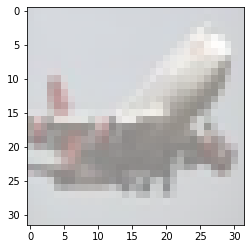

true label: plane
predict label: plane
index number: 1


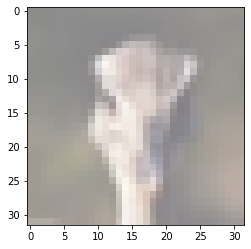

true label: bird
predict label: cat
index number: 2


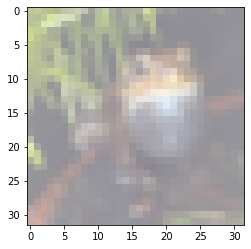

true label: frog
predict label: frog
index number: 3


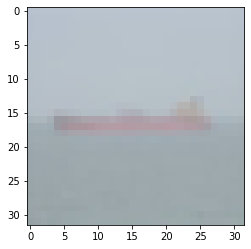

true label: ship
predict label: ship
index number: 4


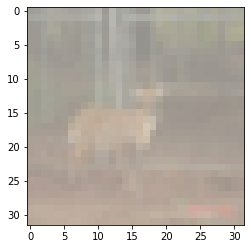

true label: deer
predict label: deer
index number: 5


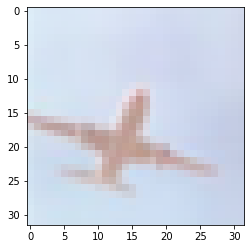

true label: plane
predict label: bird
index number: 6


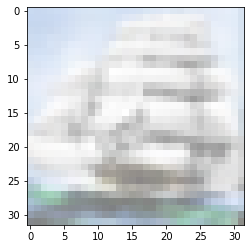

true label: ship
predict label: ship
index number: 7


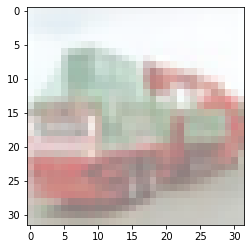

true label: truck
predict label: truck
index number: 8


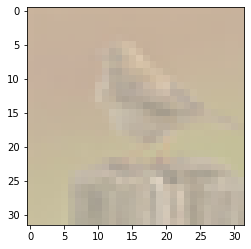

true label: bird
predict label: deer
index number: 9


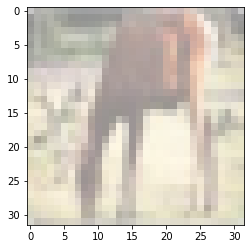

true label: deer
predict label: horse
index number: 10


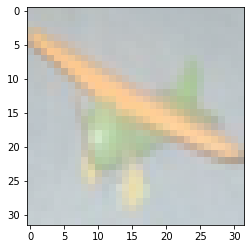

true label: plane
predict label: plane
index number:  


In [28]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction, mask, ids_restore, hidden_states, attentions= modelClassification(pixel_values=images.to(device=device))
    max_index = np.argmax(prediction[i,:].detach().numpy())
    print('predict label:',classes[max_index])